Let's look how can we combbine old competition data with the current one. For that we can do two things first:
- Run binary classification old vs new data. In ideal case samples coming from the new and old data shouldn't be separated.
- Since we have label (0\1) for each of sample of the old data, we can take models, trained only on new data and see how coherent the predictions are on the old data

In [1]:
import sys
sys.path.append('../')
import warnings
from torch.utils.data import DataLoader, Dataset
from src.pl_module import MelanomaModel
import pandas as pd
import torch
import torch.nn as nn
from typing import Tuple
import albumentations as A
from tqdm.auto import tqdm
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Load trained models and make dataset

In [2]:
def load_model(model_name: str, model_type: str, weights: str):
    print('Loading {}'.format(model_name))
    model = MelanomaModel.net_mapping(model_name, model_type)
    model.load_state_dict(
        torch.load(weights)
    )
    model.eval()
    model.cuda()
    print("Loaded model {} from checkpoint {}".format(model_name, weights))
    return model

class MelanomaDataset(Dataset):
    def __init__(self, image_folder, df, transform=None):
        super().__init__()
        self.image_folder = image_folder
        self.df = df
        self.transform = transform

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[index]
        img_id = row.image_name
        img_path = f"{self.image_folder}/{img_id}.jpg"
        image = skimage.io.imread(img_path)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image)
        target = row.target
        return{'features': image, 'img_id': img_id, 'target': target}


def get_valid_transforms():
    return A.Compose(
        [
            A.Normalize()
        ],
        p=1.0)

In [3]:
old_data = pd.read_csv('../data/external_train.csv')
old_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [4]:
model_name_list = [
    'resnest50d', 
    'resnest269e', 
    'resnest101e', 
    #'seresnext101_32x4d', 
    'tf_efficientnet_b3_ns', 
    'tf_efficientnet_b7_ns', 
    'tf_efficientnet_b5_ns']
model_type_list = ['SingleHeadMax'] * len(model_name_list)
weights_list = [
    '../weights/train_384_balancedW_resnest50d_fold0_heavyaugs_averaged_best_weights.pth',
    '../weights/07.09_train_384_balancedW_resnest269e_heavyaugs_averaged_best_weights.pth',
    '../weights/03.09_train_384_balancedW_resnest101e_fold0_heavyaugs_averaged_best_weights.pth',
    #'../weights/06.18_train_384_balancedW_seresnext101_32x4d_fold0_heavyaugs_averaged_best_weights.pth',
    '../weights/06.10_train_384_balancedW_b3_fold0_heavyaugs_averaged_best_weights.pth',
    '../weights/05.23_train_384_balancedW_b7_fold0_heavyaugs_averaged_best_weights.pth',
    '../weights/03.18_train_384_balancedW_b5_fold0_heavyaugs_averaged_best_weights.pth'
]
models = [load_model(model_name, model_type, weights) for model_name, model_type, weights in 
          zip(model_name_list, model_type_list, weights_list)]

Loading resnest50d
Loaded model resnest50d from checkpoint ../weights/train_384_balancedW_resnest50d_fold0_heavyaugs_averaged_best_weights.pth
Loading resnest269e
Loaded model resnest269e from checkpoint ../weights/07.09_train_384_balancedW_resnest269e_heavyaugs_averaged_best_weights.pth
Loading resnest101e
Loaded model resnest101e from checkpoint ../weights/03.09_train_384_balancedW_resnest101e_fold0_heavyaugs_averaged_best_weights.pth
Loading tf_efficientnet_b3_ns
Loaded model tf_efficientnet_b3_ns from checkpoint ../weights/06.10_train_384_balancedW_b3_fold0_heavyaugs_averaged_best_weights.pth
Loading tf_efficientnet_b7_ns
Loaded model tf_efficientnet_b7_ns from checkpoint ../weights/05.23_train_384_balancedW_b7_fold0_heavyaugs_averaged_best_weights.pth
Loading tf_efficientnet_b5_ns
Loaded model tf_efficientnet_b5_ns from checkpoint ../weights/03.18_train_384_balancedW_b5_fold0_heavyaugs_averaged_best_weights.pth


In [5]:
dataset = MelanomaDataset('../data/jpeg-isic2019-384x384/train/', old_data, get_valid_transforms())
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)

In [6]:
targets_list = []
cv_cls_1_list = []
mean_cls_1_list = []
std_cls_1_list = []
for batch in tqdm(dataloader, total=len(dataloader)):
    with torch.no_grad():
        preds = [nn.Sigmoid()(model(batch['features'].cuda())) for model in models]
        preds = torch.stack(preds)
        mean_cls_1 = preds[..., 0].cpu().numpy().mean(axis=0)
        std_cls_1 = preds[..., 0].cpu().numpy().std(axis=0)
        cv_cls_1 = std_cls_1 / mean_cls_1
        targets_list.extend(batch['target'].cpu().numpy())
        mean_cls_1_list.extend(mean_cls_1)
        cv_cls_1_list.extend(cv_cls_1)
        std_cls_1_list.extend(std_cls_1)

In [7]:
targets_list = np.array(targets_list)
cv_cls_1_list = np.array(cv_cls_1_list)
mean_cls_1_list = np.array(mean_cls_1_list)
std_cls_1_list = np.array(std_cls_1_list)

In [8]:
thr_pred = 0.5
predicted_cls = (mean_cls_1_list >= thr_pred).astype(int)

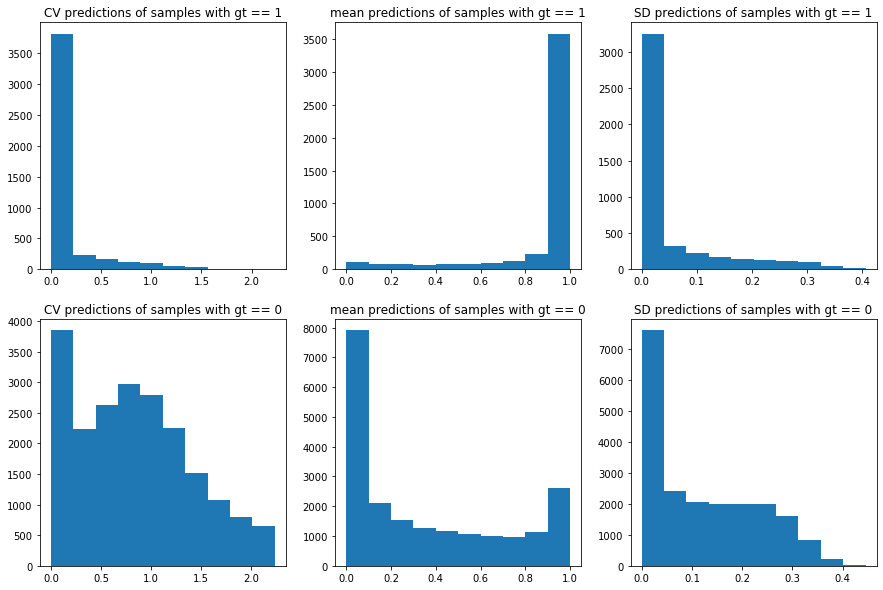

In [9]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].hist(cv_cls_1_list[targets_list==1])
ax[0, 0].set_title('CV predictions of samples with gt == 1')
ax[0, 1].hist(mean_cls_1_list[targets_list==1])
ax[0, 1].set_title('mean predictions of samples with gt == 1')
ax[0, 2].hist(std_cls_1_list[targets_list==1])
ax[0, 2].set_title('SD predictions of samples with gt == 1')
ax[1, 0].hist(cv_cls_1_list[targets_list==0])
ax[1, 0].set_title('CV predictions of samples with gt == 0')
ax[1, 1].hist(mean_cls_1_list[targets_list==0])
ax[1, 1].set_title('mean predictions of samples with gt == 0');
ax[1, 2].hist(std_cls_1_list[targets_list==0])
ax[1, 2].set_title('SD predictions of samples with gt == 0');
#plt.hist(cv_cls_1_list);

We can take only confident predictions, that is CV <= 0.5 for both classes + predicted class  == gt class

In [10]:
old_data.loc[:, 'predicted_target'] = predicted_cls
old_data.loc[:, 'prediction_mean'] = mean_cls_1_list
old_data.loc[:, 'CV'] = cv_cls_1_list
old_data.loc[:, 'std'] = std_cls_1_list
old_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,predicted_target,prediction_mean,CV,std
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767,1,0.754775,0.261200,0.197147
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,0,0.227542,0.871334,0.198265
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,1,0.997244,0.003113,0.003105
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,1,0.967942,0.029416,0.028473
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,1,0.987594,0.013393,0.013227


In [11]:
selection_mask = (std_cls_1_list <= 0.15) & (predicted_cls == targets_list)

In [12]:
old_data_cleaned = old_data.loc[selection_mask, :]
old_data_cleaned.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,predicted_target,prediction_mean,CV,std
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,1,0.997244,0.003113,0.003105
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,1,0.987594,0.013393,0.013227
5,ISIC_0000006,-1,female,25.0,posterior torso,NV,benign,0,0,1022,767,0,0.000208,1.406533,0.000293
6,ISIC_0000007,-1,female,25.0,posterior torso,NV,benign,0,16,1022,767,0,0.003350,0.978055,0.003277
9,ISIC_0000010,-1,female,35.0,posterior torso,NV,benign,0,16,1022,767,0,0.009744,0.881967,0.008594


In [13]:
old_data_cleaned.target.value_counts()

0    9247
1    3748
Name: target, dtype: int64

In [14]:
old_data.target.value_counts()

0    20763
1     4509
Name: target, dtype: int64

In [15]:
#now replace target with soft labels
old_data_cleaned['old_target'] = old_data_cleaned['target']
old_data_cleaned['target'] = old_data_cleaned['prediction_mean']
old_data_cleaned.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,predicted_target,prediction_mean,CV,std,old_target
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,0.997244,0,1022,767,1,0.997244,0.003113,0.003105,1
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,0.987594,14,1022,767,1,0.987594,0.013393,0.013227,1
5,ISIC_0000006,-1,female,25.0,posterior torso,NV,benign,0.000208,0,1022,767,0,0.000208,1.406533,0.000293,0
6,ISIC_0000007,-1,female,25.0,posterior torso,NV,benign,0.003350,16,1022,767,0,0.003350,0.978055,0.003277,0
9,ISIC_0000010,-1,female,35.0,posterior torso,NV,benign,0.009744,16,1022,767,0,0.009744,0.881967,0.008594,0


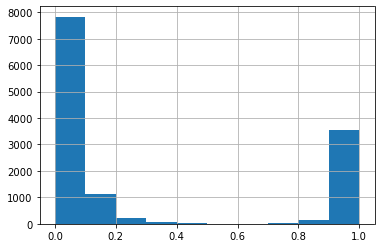

In [16]:
old_data_cleaned['target'].hist()

In [17]:
old_data_cleaned.to_csv('../data/external_train_cleaned.csv', index=False)